In [1]:
import os
os.chdir("../")
import numpy as np
import torch as th
from glob import glob
from utils import *
import ray
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from alphagen.config import HORIZON_BACK
from concurrent.futures import ProcessPoolExecutor


In [2]:
json_paths = glob("checkpoints/*ret1d*")
json_paths = [
    sorted(
        glob(f"{name}/*.json"),
        key=lambda x: int(x.split("/")[-1].split("_")[0]),
    )[-1]
    for name in json_paths
]


In [3]:
def json_to_factor(path):
    data = ArgData(
    start_time=20190103,
    end_time=20211231,
    device=torch.device("cpu"),
    max_backtrack_days=HORIZON_BACK,
)
    with open(path, "r") as f:
        alpha = json.load(f)
    factors = [
        Feature(getattr(FeatureType, expr[1:])).evaluate(data)
        if expr[0] == "$"
        else formula_to_expression(expr).evaluate(data)
        for expr in alpha["exprs"]
    ]
    weights = torch.tensor(alpha["weights"])
    factor_value = sum(f * w for f, w in zip(factors, weights))
    factor_value = normalize_by_day(factor_value)
    return factor_value


In [5]:
from tqdm import tqdm
alphas = []
for path in tqdm(json_paths):
    alphas.append(json_to_factor(path))

 74%|███████▎  | 42/57 [1:19:34<43:47, 175.16s/it]

In [4]:
alphas = []
with ProcessPoolExecutor(60) as executor:
    alphas  = list(executor.map(json_to_factor,json_paths))

/home/ray/workspace/alphagen/alphagen/data/expression_ocean.py:160: RuntimeWarning: divide by zero encountered in divide
  nx = bk.nanrankdata(nx, axis=1) / validnum - 0.5


RuntimeError: [enforce fail at alloc_cpu.cpp:75] err == 0. DefaultCPUAllocator: can't allocate memory: you tried to allocate 17718480000 bytes. Error code 12 (Cannot allocate memory)

In [ ]:
sig_ret1d = th.stack([i for i in alphas], dim=-1)

In [ ]:
sig_np =  sig_ret1d.numpy().astype(np.float32)
np.save('./sig_ret1d.npy',sig_np)

In [ ]:
sig_ret1d = th.concatenate(
    [th.zeros(HORIZON_BACK, 6000, len(alphas)), sig_ret1d], dim=0
)


In [ ]:
sig_ret1d.shape

torch.Size([11664, 6000, 33])

In [ ]:
ret1d  =  np.load( "/home/public2/share_yw/data/basic_info/RET1D.npy",).reshape(-1,6000)
ret2d  =  np.load( "/home/public2/share_yw/data/basic_info/RET2D.npy",).reshape(-1,6000)
ret5d  = np.load( "/home/public2/share_yw/data/basic_info/RET5D.npy",).reshape(-1,6000)

In [ ]:
ic1d = []
ret1d = th.tensor(ret1d, dtype=th.float32)
ret2d = th.tensor(ret2d, dtype=th.float32)
ret5d = th.tensor(ret5d, dtype=th.float32)
for i in range(sig_ret1d.shape[-1]):
    ic1d.append(batch_pearsonr(sig_ret1d[..., i], ret1d))


In [ ]:
mean_ic = [th.mean(i) for i in ic1d]


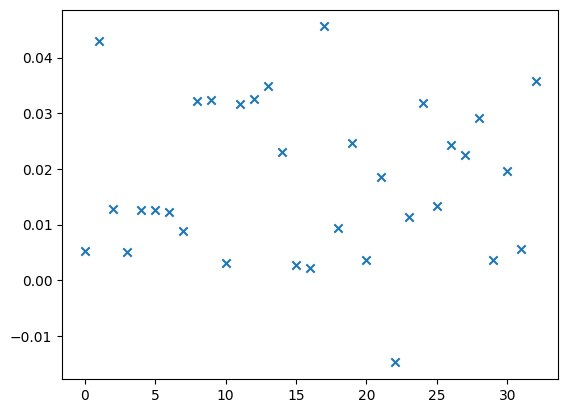

In [ ]:
plt.scatter(x=np.arange(len(mean_ic)),y=mean_ic,marker="x")

In [ ]:
split_idx = 486 * 16


In [ ]:
demo = ic1d[0]
demo = np.array(demo)


In [ ]:
demo.shape

(11664,)

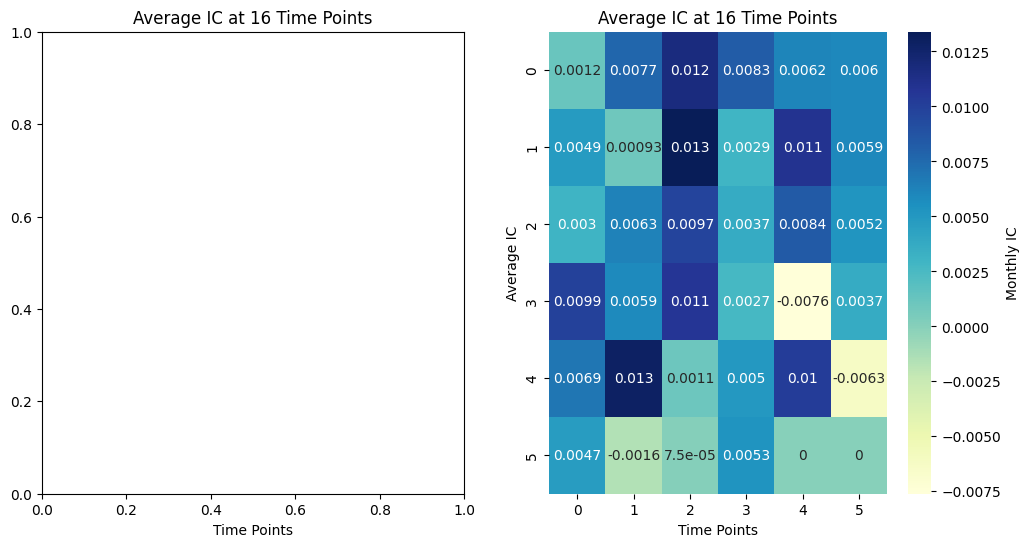

Text(0.5, 1.0, 'Monthly IC for 3 Years (6x6 Grid)')

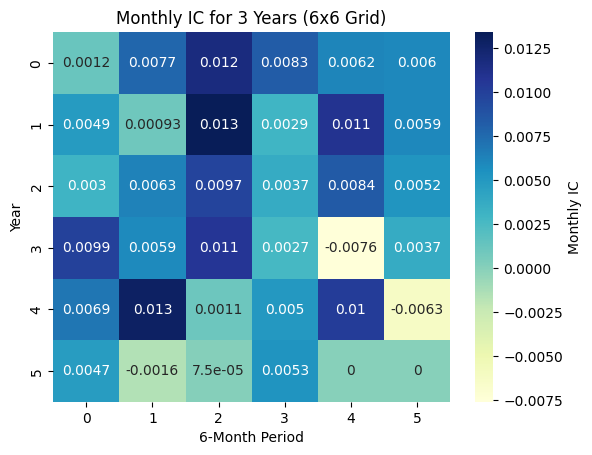

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
reshaped_demo = demo.reshape(-1,16)
average_ic_16_points = np.mean(reshaped_demo, axis=0)

num_months = reshaped_demo.shape[0] // 21

monthly_ic = np.mean(reshaped_demo[:num_months * 21].reshape(num_months, 21, 16), axis=1).mean(axis=1)

padded_monthly_ic = np.pad(monthly_ic, (0, 36 - len(monthly_ic)), 'constant')
monthly_ic_reshaped = padded_monthly_ic.reshape(6, 6)
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
monthly_ic = np.mean(
    reshaped_demo[: num_months * 21].reshape(num_months, 21, 16), axis=1
).mean(axis=1)
plt.xlabel('Time Points')
padded_monthly_ic = np.pad(monthly_ic, (0, 36 - len(monthly_ic)), "constant")
plt.title('Average IC at 16 Time Points')

plt.subplot(1, 2, 2)
sns.heatmap(monthly_ic_reshaped, annot=True, cmap="YlGnBu", cbar_kws={'label': 'Monthly IC'})
plt.xlabel('6-Month Period')
plt.ylabel('Year')
plt.xlabel("Time Points")
plt.ylabel("Average IC")
plt.title("Average IC at 16 Time Points")
plt.show()
sns.heatmap(
    monthly_ic_reshaped, annot=True, cmap="YlGnBu", cbar_kws={"label": "Monthly IC"}
)
plt.xlabel("6-Month Period")
plt.ylabel("Year")
plt.title("Monthly IC for 3 Years (6x6 Grid)")
